# Dataset Loading


In [1]:
import pandas as pd
import numpy as np

In [2]:
from utils.text_cleaning_utils import TextCleaner

def preprocess_text_for_svm(df, text_column):
    """
    Preprocess text data for SVM model
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the text data
    text_column : str
        Name of the column containing text to be processed
    
    Returns:
    --------
    pandas DataFrame
        DataFrame with preprocessed text and tokenized embeddings
    """
    # Initialize text cleaner
    text_cleaner = TextCleaner()
    
    # Apply text cleaning functions
    processed_text = (df[text_column]
                     .apply(text_cleaner.remove_digits)
                     .apply(text_cleaner.remove_english_and_special_chars)
                     .apply(text_cleaner.remove_stopwords)
                     .apply(text_cleaner.remove_emojis))
    
    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    processed_df = df.copy()
    processed_df[text_column] = processed_text
    
    # Tokenize the clean text
    tokenizer = SentencepieceTokenizer()
    processed_df['tokenized_text'] = processed_df[text_column].apply(
        lambda x: tokenizer.tokenize(x) if isinstance(x, str) else []
    )
    
    # Get embeddings for each token
    fast_text_embedding = BengaliFasttext()
    processed_df['embeddings'] = processed_df['tokenized_text'].apply(
        lambda tokens: get_embeddings(tokens, fast_text_embedding)
    )
    
    return processed_df

cleaned_comments_dataset = pd.read_csv(
    "../dataset/cleaned_comments_dataset.csv",
    encoding="utf-8",
    engine="pyarrow",
)

only_augmented_comments_dataset = pd.read_csv(
    "../dataset/only_augmented_comments_dataset.csv",
    encoding="utf-8",
    engine="pyarrow",
)

In [3]:
label_encoding_dict = {
    "not bully": 0,
    "religious": 1,
    "troll": 2,
    "sexual": 3,
    "threat": 4,
}

cleaned_comments_dataset["label"] = cleaned_comments_dataset["label"].map(
    label_encoding_dict
)

only_augmented_comments_dataset["label"] = only_augmented_comments_dataset["label"].map(
    label_encoding_dict
)

In [4]:
cleaned_comments_dataset

,comment,label
0,হালার পুত মদ খাওয়ার সময় রাতের বেলা মদ খাই দি...,3
1,ঘরে শুট কেমন লেগেছে ক্যামেরাতে,0
2,অরে বাবা টা পাগল,0
3,ক্যাপ্টেন অফ বাংলাদেশ,0
4,পটকা মাছ,2
...,...,...
43562,হিরো আলম এগিয়ে যাও,0
43563,হিরো আলমকে সাপোর্ট অসংখ্য ধন্যবাদ আপনাকে,0
43564,হিরো ভাই এগিয়ে য়াও,0
43565,হুম ভাও তোমরা এগিয়ে যাও তোমাদের পিছনে আছি,0


In [5]:
only_augmented_comments_dataset

,text,label
0,খানকিরা জানে খানকি বিত্তি কিভাবে আল্লাহতালা নর...,1
1,তুই বড়যাত্রা এসেছ জুতা দেখেশিসতাহলে তর মাবাপের...,4
2,এক সাক্ষাৎকারে মেয়েটি বলেছে বিশ্বাস না। ইসলাম...,1
3,নাস্তিকের প্রার্থনা,1
4,আজকাল লম্পট অশিক্ষিত ব্যক্তি মুখ বের আনে শীঘ্র...,1
...,...,...
6076,দেশ রুপার বিতাড়িত,4
6077,জুতাটা কপালে মেরেছি।,4
6078,সেফু নামক এক ইসলাম বিদ্বেষীর কুরআন রাসুল সঃ অপ...,4
6079,জুতা মেরে গরু দান পুকি মেরে দিলা।,4


### Importing the Tokenization and Necessary Libraries


In [6]:
from bnlp import SentencepieceTokenizer
from bnlp.embedding.fasttext import BengaliFasttext
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [7]:
tokenizer = SentencepieceTokenizer()
fast_text_embedding = BengaliFasttext()

In [8]:
def get_embeddings(tokens):
    # Initialize an empty list to store embeddings for each token
    embeddings = []

    # Get embedding for each token in the token list
    for token in tokens:
        try:
            embedding = fast_text_embedding.get_word_vector(token)
            embeddings.append(embedding)
        except:
            # If token doesn't have an embedding, skip it
            continue

    return embeddings


# Convert list of token embeddings to a single fixed-length vector by taking the mean
def get_mean_embedding(embeddings_list):
    if not embeddings_list:  # Handle empty lists
        return np.zeros(100)  # Fasttext embeddings are of length 100
    return np.mean(embeddings_list, axis=0)


def tokenize_and_generate_embeddings(text_series: pd.Series):

    tokenized_series = text_series.apply(
        lambda x: tokenizer.tokenize(x) if isinstance(x, str) else []
    )

    # print("Tokenized Series", tokenized_series)

    embeddings_series = tokenized_series.apply(lambda tokens: get_embeddings(tokens))

    # print("Embeddings Series", embeddings_series)

    mean_embedding = embeddings_series.apply(get_mean_embedding)

    # print("Mean Embedding", mean_embedding)

    return mean_embedding

In [19]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
import seaborn as sns

import matplotlib.pyplot as plt

class_encoding_dict = {
    0: "not bully",
    1: "religious",
    2: "troll",
    3: "sexual",
    4: "threat",
}


def evaluate_model_performance(model, X_test, y_test, class_names=None):
    """
    Evaluates and prints various performance metrics for a classification model

    Parameters:
    -----------
    model : trained classifier model with predict method
        The trained model to evaluate
    X_test : array-like
        Test features
    y_test : array-like
        True labels for test data
    class_names : list, optional
        Names of the classes (used for confusion matrix)

    Returns:
    --------
    dict
        Dictionary containing all calculated metrics
    """
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Print metrics
    print("Model Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    if class_names is None:
        class_names = [
            f"{class_encoding_dict[i]}" for i in range(len(np.unique(y_test)))
        ]

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Return metrics as dictionary
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm,
    }


# Example usage:
# class_names = ["not bully", "religious", "troll", "sexual", "threat"]
# metrics = evaluate_model_performance(svm_model, test_X_vectors, test_y, class_names)

# SVM Run on Original Dataset

### Train Test Split

In [10]:
svm_model = SVC(kernel="linear")

In [11]:
trainX, testX, trainY, testY = train_test_split(
    cleaned_comments_dataset["comment"],
    cleaned_comments_dataset["label"],
    test_size=0.2,
)

In [15]:
embeddings_train_X = tokenize_and_generate_embeddings(trainX)
embeddings_test_X = tokenize_and_generate_embeddings(testX)

In [16]:
svm_model.fit(list(embeddings_train_X), trainY)

SVC(kernel='linear')

Model Performance Metrics:
Accuracy: 0.5933
Precision: 0.5931
Recall: 0.5933
F1 Score: 0.5811


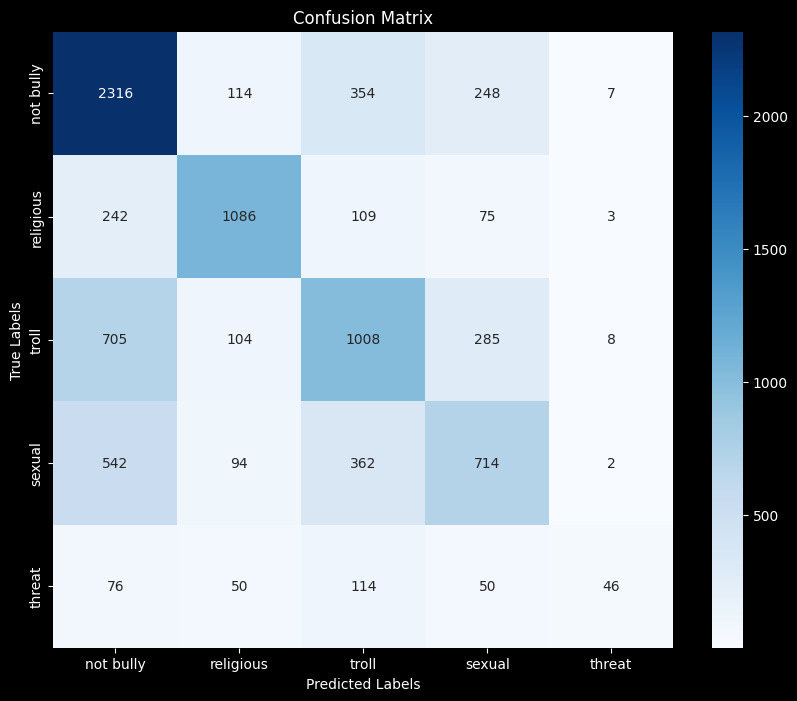

{'accuracy': 0.5932981409226532,
 'precision': 0.5931068768704691,
 'recall': 0.5932981409226532,
 'f1': 0.5810507967016378,
 'confusion_matrix': array([[2316,  114,  354,  248,    7],
        [ 242, 1086,  109,   75,    3],
        [ 705,  104, 1008,  285,    8],
        [ 542,   94,  362,  714,    2],
        [  76,   50,  114,   50,   46]], dtype=int64)}

In [20]:
evaluate_model_performance(svm_model, list(embeddings_test_X), testY)

# SVM Run on Original + Augmented Dataset

In [22]:
trainX, testX, trainY, testY = train_test_split(
    cleaned_comments_dataset["comment"],
    cleaned_comments_dataset["label"],
    test_size=0.2,
)

# Use pd.concat instead of append for Series objects
extended_trainX = pd.concat([trainX, only_augmented_comments_dataset["text"]])
extended_trainY = pd.concat([trainY, only_augmented_comments_dataset["label"]])

In [24]:
extended_embeddings_train_X = tokenize_and_generate_embeddings(extended_trainX)
embeddings_test_X = tokenize_and_generate_embeddings(testX)

In [25]:
svm_model_extended = SVC(kernel="linear")

In [26]:
svm_model_extended.fit(list(extended_embeddings_train_X), extended_trainY)

SVC(kernel='linear')

Model Performance Metrics:
Accuracy: 0.6025
Precision: 0.5933
Recall: 0.6025
F1 Score: 0.5931


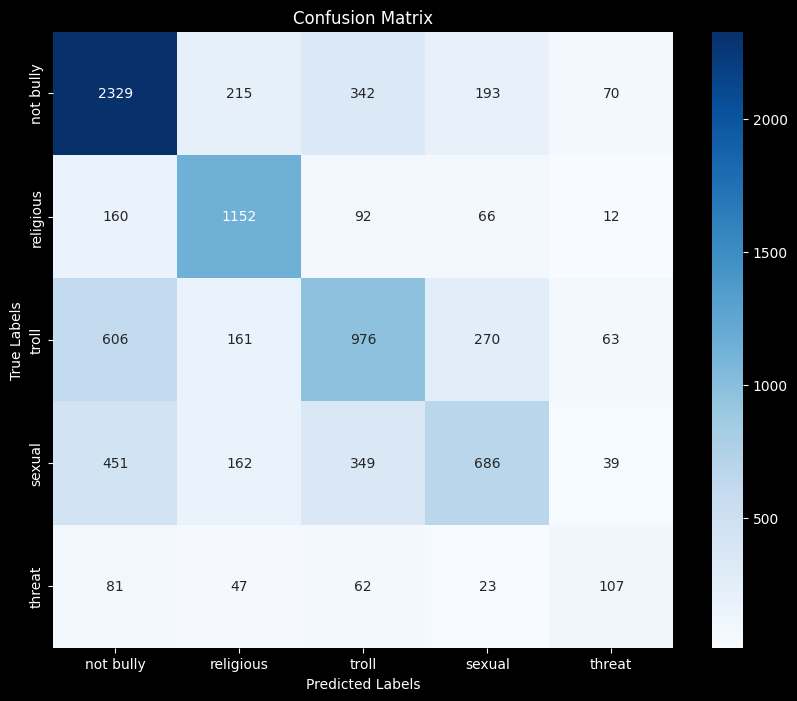

{'accuracy': 0.602478769795731,
 'precision': 0.593307147173346,
 'recall': 0.602478769795731,
 'f1': 0.5931482652732828,
 'confusion_matrix': array([[2329,  215,  342,  193,   70],
        [ 160, 1152,   92,   66,   12],
        [ 606,  161,  976,  270,   63],
        [ 451,  162,  349,  686,   39],
        [  81,   47,   62,   23,  107]], dtype=int64)}

In [27]:
evaluate_model_performance(svm_model_extended, list(embeddings_test_X), testY)

# SVM Run on Original + Augmented Dataset + Hyperparameter Tuning

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

# Define parameter grid to search
param_grid = {
    "C": [0.1, 1, 10, 100],
    "kernel": ["linear", "rbf", "poly"],
    "gamma": ["scale", "auto", 0.1, 0.01, 0.001],
    "class_weight": ["balanced", None],
}

# Create an SVM classifier
svm_base = SVC(probability=True, random_state=42)

# Custom scorer for optimization (F1 score with weighted average)
f1_scorer = make_scorer(f1_score, average="weighted")

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=svm_base,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=5,
    n_jobs=-1,  # Use all available cores
    verbose=1,
)

# Fit the grid search to the data
print("Starting grid search...")
grid_search.fit(list(extended_embeddings_train_X), extended_trainY)

# Get best parameters and best estimator
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Create optimized SVM model with best parameters
svm_optimized = grid_search.best_estimator_

# Evaluate the optimized model
print("\nEvaluating optimized model performance:")
optimized_metrics = evaluate_model_performance(
    svm_optimized, list(embeddings_test_X), testY
)

Starting grid search...
Fitting 5 folds for each of 120 candidates, totalling 600 fits


: 